# Descriptive analysis

## Outline

    1. Load libraries
    2. Load and prepare data
    3. Summary statistics
    4. Plots

## 1. Load libraries

In [2]:
# General libraries
import pandas as pd
import numpy as np

# Calculation and model building
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.tsa.stattools, statsmodels.graphics.tsaplots
from sklearn.metrics import mean_absolute_error

# Plotting
import plotly.graph_objects as go
import plotly.express as px
plt.style.use('seaborn-paper')
%matplotlib inline

import seaborn as sns
sns.set_style('dark')

## 2. Load and prepare data

In [3]:
# Input the folder where your data is located here:
data_source_folder = ''

# Load Data
df_consumption = pd.read_csv("{}/consumption_prepared.csv".format(data_source_folder), sep=",", decimal = ',')

In [4]:
# Turn consumptino values into floats
df_consumption['consumption'] = df_consumption['consumption'].astype(float)

df_consumption['date'] =  pd.to_datetime(df_consumption['date'])
# Set index to date
df_consumption['date1'] = pd.date_range(start = '01/01/2018 00:00:00', periods = 43680, freq = '15T')
df_consumption.set_index('date1', inplace=True)


### Load weather data

In [30]:
# Load weather Data
df_weather = pd.read_csv("{}/daily_weather_avg.csv".format(data_source_folder), sep=",", decimal = ',')

In [33]:
df_weather = df_weather[['temp', 'wind', 'cloud']].astype(float)

In [34]:
df_weather = df_weather.iloc[1:, :]
df_weather['date1'] = pd.date_range(start = '01/01/2018', periods = 455, freq = 'D')
df_weather.set_index('date1', inplace=True)

## 3. Summary statistics

In [28]:
# Summary statistics
df_consumption.describe()

,consumption
count,43680.000000
mean,21.622524
std,3.591004
min,13.438527
25%,18.646872
50%,21.640809
75%,24.754196
max,30.092488


In [35]:
df_weather.describe()

,temp,wind,cloud
count,455.000000,455.000000,455.000000
mean,10.556484,3.829084,0.670962
std,7.069719,1.721619,0.258995
min,0.166667,1.333333,0.000000
25%,4.650000,2.533333,0.504167
50%,9.133333,3.366667,0.741667
75%,16.766667,4.550000,0.883333
max,27.566667,10.400000,1.000000


### Correlations between daily averages variables

In [36]:
# Compute daily consumption averages
daily_consumption = df_consumption['consumption'].resample('D').mean()

In [37]:
# calculate Pearson's correlation
corr_temp, _ = pearsonr(df_weather['temp'],daily_consumption)
corr_wind, _ = pearsonr(df_weather['wind'],daily_consumption)
corr_cloud, _ = pearsonr(df_weather['cloud'],daily_consumption)
print('Pearsons correlation between consumption and temperature: %.3f' % corr_temp)
print('Pearsons correlation between consumption and wind: %.3f' % corr_wind)
print('Pearsons correlation between consumption and cloud: %.3f' % corr_cloud)

Pearsons correlation between consumption and temperature: -0.416
Pearsons correlation between consumption and wind: 0.236
Pearsons correlation between consumption and cloud: 0.177


## 4. Plots


### Plot autocorrelation of variables

In [38]:
df_acf = df_consumption.iloc[-10000:, :] # include only last 10000 values
df_acf = pd.DataFrame(df_acf['consumption'].resample('H').mean())

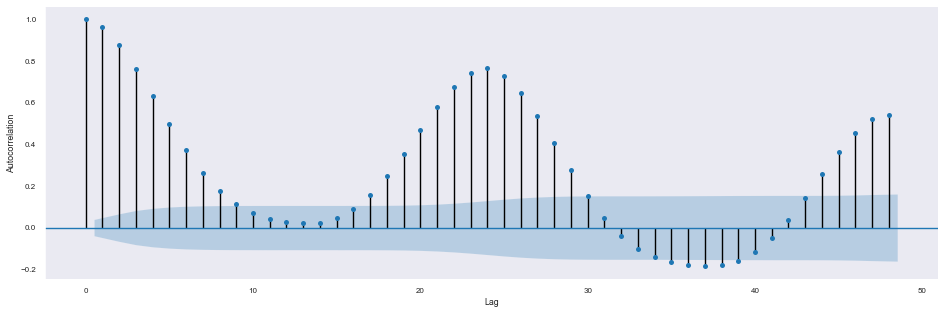

In [39]:
# Autocorrelation of the variable consumption
plt.rc("figure", figsize=(16,5))
acf_ts = df_acf['consumption'].to_numpy()
acf_plot = plot_acf(acf_ts, lags=48, title = '')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
sns.despine()
plt.show()

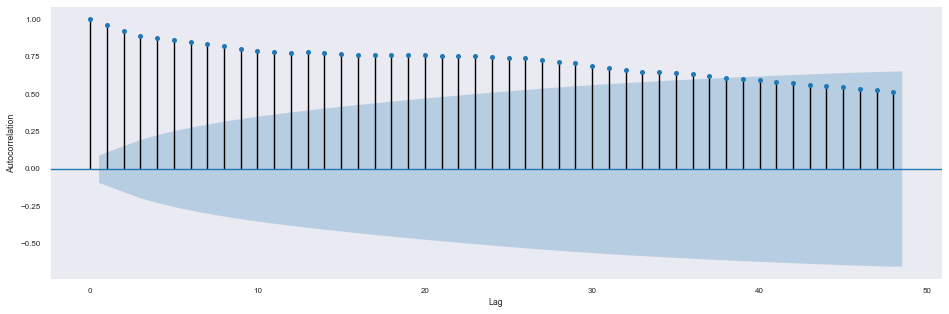

In [40]:
#Autocorrelation of the variable temperature
plt.rc("figure", figsize=(16,5))
acf_ts = df_weather['temp'].to_numpy()
acf_plot = plot_acf(acf_ts, lags=48, title = '')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
sns.despine()
plt.show()

### Plot year 2018 with 24 hour rolling average

In [41]:
# Create subset with electricity consumption for year 2018
df_consumption_one_year = df_consumption.copy()

# Calculate 24h rolling average
df_consumption_one_year['consumption_daily_ave'] = df_consumption.consumption.rolling(96).mean().shift(-60)

# Subset to relevant time
df_mask = (df_consumption_one_year['date']>'2017-12-30') & (df_consumption_one_year['date'] < '2019-01-01')
df_consumption_one_year = df_consumption_one_year.loc[df_mask]

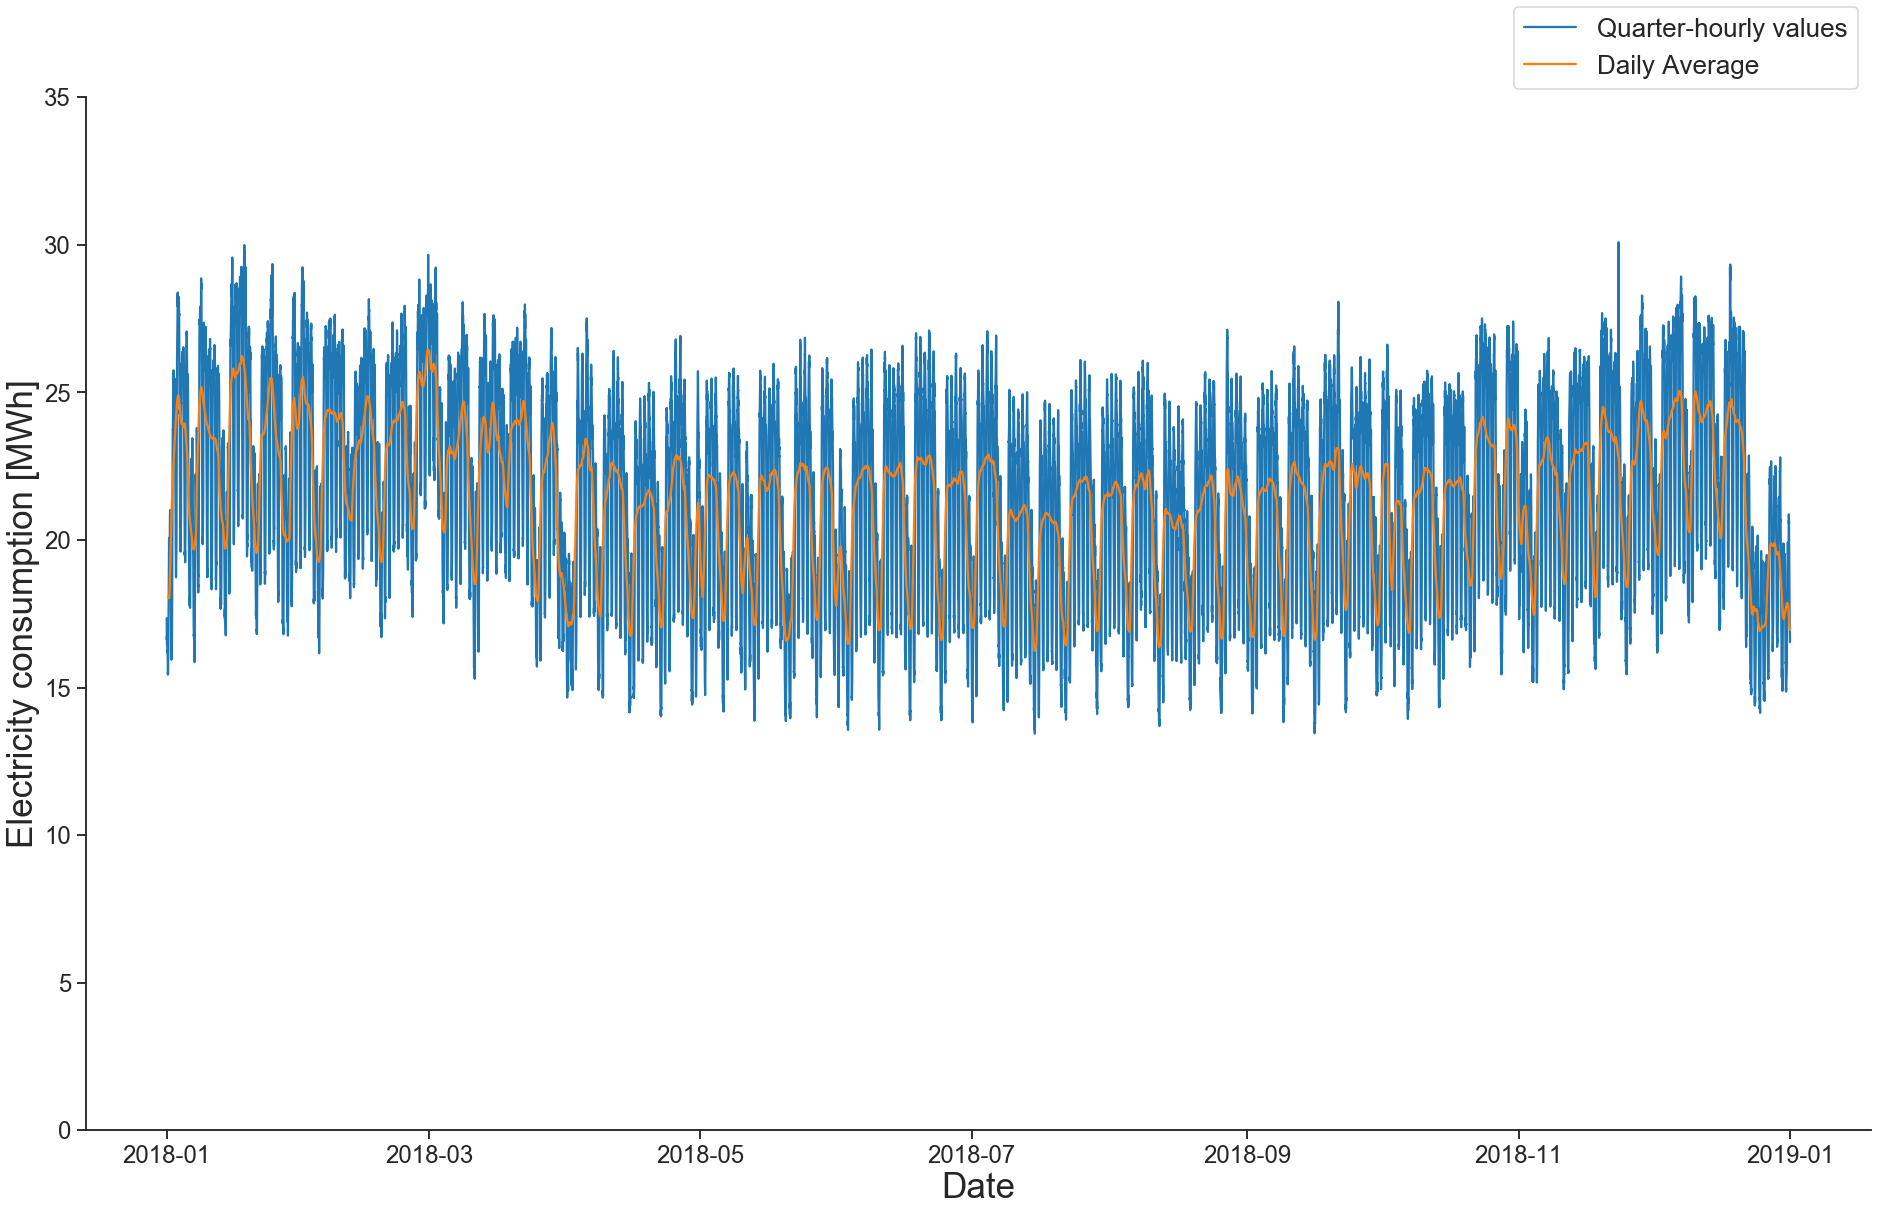

In [42]:
# Plot Electricity consumption over one year including a 24 hour rolling average
sns.set_context("talk")
sns.set_style('ticks')

# set figure size
plt.figure(figsize=(32,19))

# Time series plot with Seaborn lineplot() with label
pxd = sns.lineplot(x="date",y="consumption",
             label="Quarter-hourly values", data=df_consumption_one_year,
             ci=None, color = 'tab:blue')

# 7-day rolling average Time series plot with Seaborn lineplot() with label
pxd = sns.lineplot(x="date",y="consumption_daily_ave",
             label="Daily Average",
             data=df_consumption_one_year,
             ci=None, color = 'tab:orange')

# set axis labels
plt.setp(pxd.get_legend().get_texts(), fontsize='25') 
plt.xlabel("Date", size=35)
plt.ylabel("Electricity consumption [MWh]", size=35)
plt.yticks(fontsize = 24)
plt.xticks(fontsize = 24)
pxd.set(ylim=(0, 35))
plt.legend(loc='upper right', fontsize=26, bbox_to_anchor=(1, 1.1))
sns.despine()

#### Calculate average consumption summer and winter

In [16]:
# df_summer
df_mask = (df_consumption['date']>'2018/12/23') & (df_consumption['date']<'2018/12/29')
df_summer = df_consumption.loc[df_mask]
avg_consumption_summer = round(np.mean(df_summer['consumption']), 2)
print('In summer months, the average consumption is: {} MWh.'.format(avg_consumption_summer))

In summer months, the average consumption is: 18.14 MWh.


In [17]:
# df_winter
#df_mask = (df_consumption['date']>'2019/12/23') & (df_consumption['date']<'2019/12/29')
df_winter=df_consumption.loc[-df_mask]
avg_consumption_winter = round(np.mean(df_winter['consumption']), 2)
print('In winter months, the average consumption is: {} MWh.'.format(avg_consumption_winter))

In winter months, the average consumption is: 21.67 MWh.


In [18]:
# Percentage difference summer and winter
diff = round((1-avg_consumption_summer/avg_consumption_winter)*100, 2)
print("In summer months the consumption is on average {} % lower.".format(diff))

In summer months the consumption is on average 16.29 % lower.


### Plot one week of data

In [43]:
# Percentage difference summer and winter
df_one_week=df_consumption.loc[(df_consumption['date']>'2018/06/04') & (df_consumption['date']<'2018/06/11')]

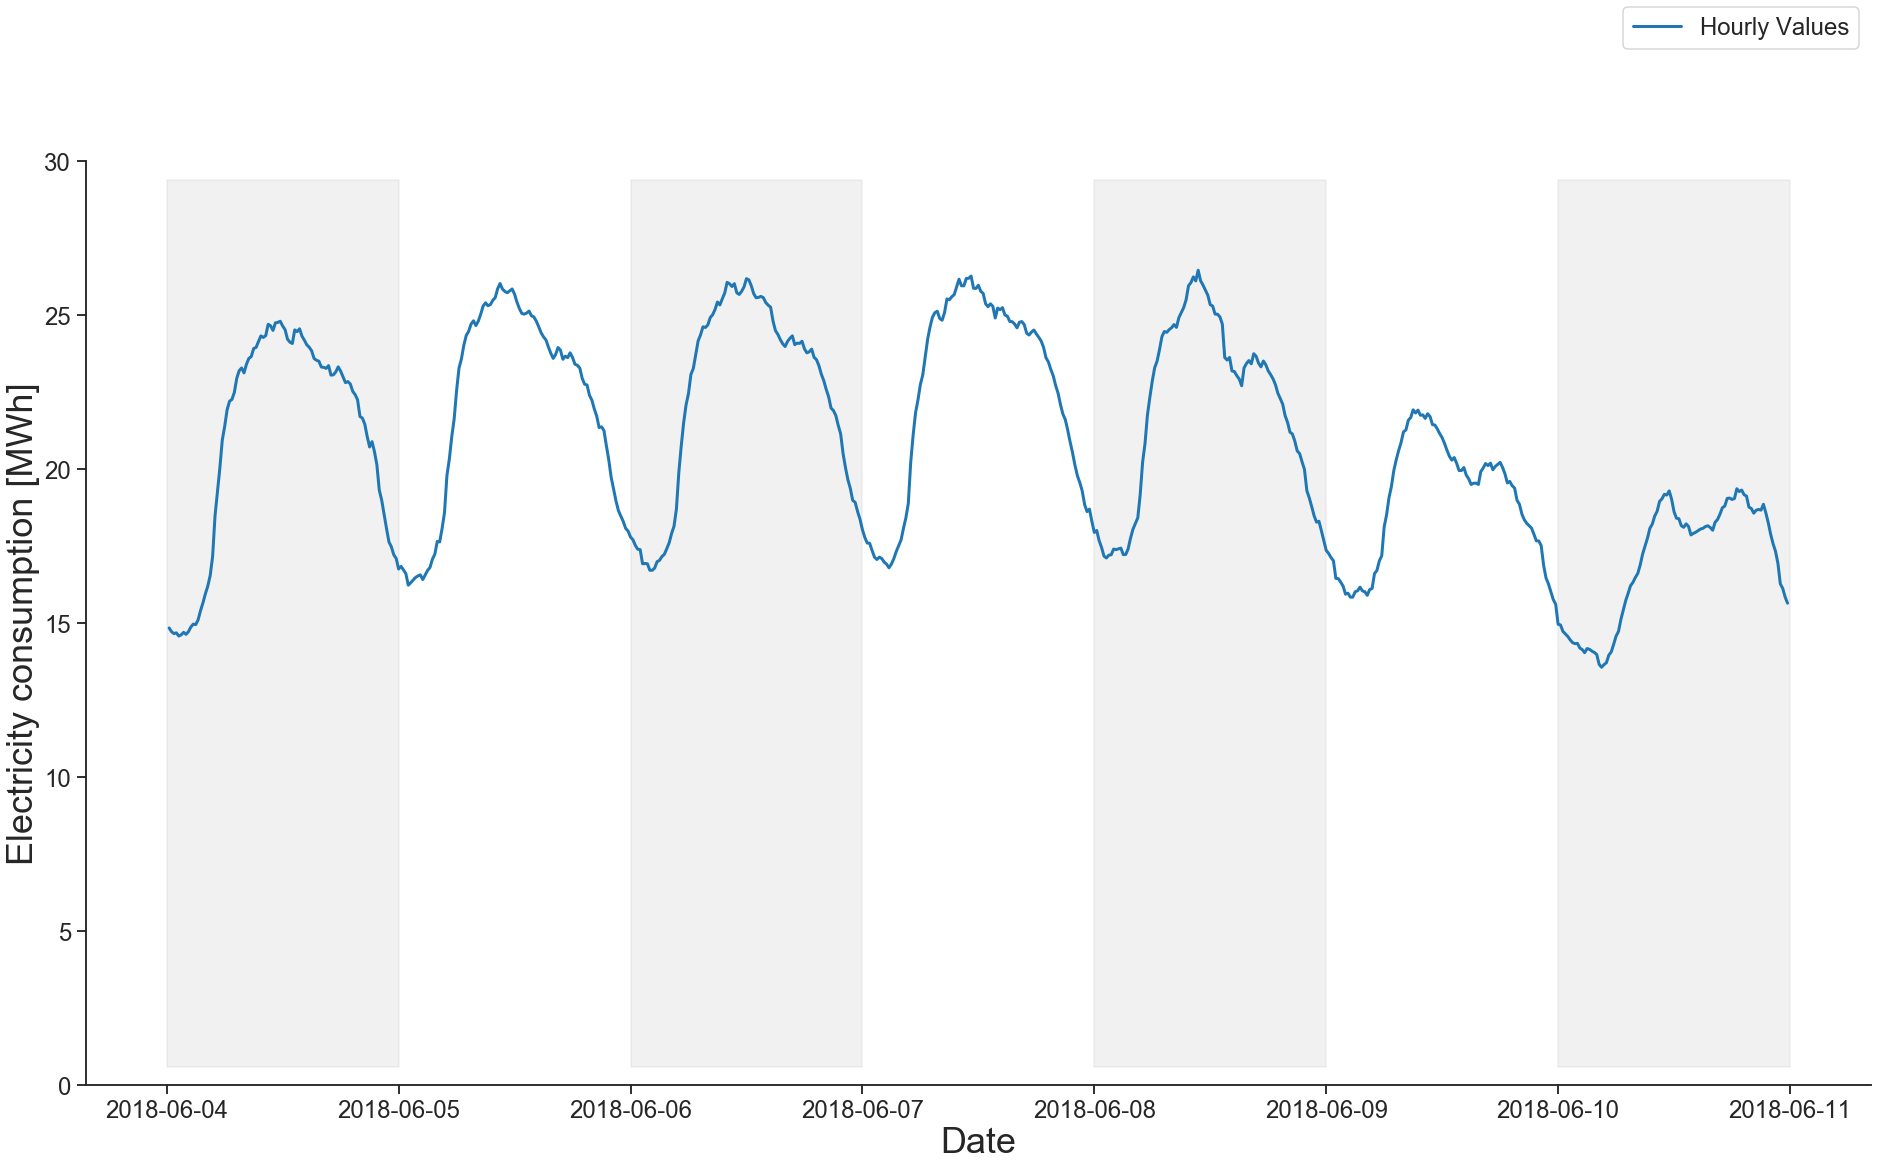

In [44]:
from datetime import datetime
from matplotlib.dates import date2num
# bigger plot elements suitable for giving talks
sns.set_context("talk")
sns.set_style('ticks')
# set figure size
fig, ax = plt.subplots(figsize=(32,17))
# Time series plot with Seaborn lineplot() with label
pxd = sns.lineplot(x="date",y="consumption",
             label="Hourly Values", data=df_one_week,
             ci=None, color = 'tab:blue', linewidth = 3)

# set axis labels
plt.setp(pxd.get_legend().get_texts(), fontsize='25') 
plt.xlabel("Date", size=36)
plt.ylabel("Electricity consumption [MWh]", size=36)
plt.yticks(fontsize = 24)
plt.xticks(fontsize = 24)

# add shades on days
ax.axvspan(date2num(datetime(2018,6,4)), date2num(datetime(2018,6,5)),0.02,0.98, alpha=0.1, color='tab:grey')
ax.axvspan(date2num(datetime(2018,6,6)), date2num(datetime(2018,6,7)),0.02,0.98, alpha=0.1, color='tab:grey')
ax.axvspan(date2num(datetime(2018,6,8)), date2num(datetime(2018,6,9)),0.02,0.98, alpha=0.1, color='tab:grey')
ax.axvspan(date2num(datetime(2018,6,10)), date2num(datetime(2018,6,11)),0.02,0.98, alpha=0.1, color='tab:grey')

pxd.set(ylim=(0, 30))
plt.legend(loc='upper right', fontsize=24, bbox_to_anchor=(1, 1.18))
sns.despine()

### Boxplot of daily electricity consumption

In [45]:
def transform_to_windows(data, window, load_type='consumption'):
    
    #from the original datetime index create new columns with each of the year, month, day, and hour.
    data.loc[:,'year'] = data.index.year
    data.loc[:,'month'] = data.index.month
    data.loc[:,'day'] = data.index.day
    data.loc[:,'hours'] = data.index.hour
    
    #construct datetimes from the split year, month, day columns
    data.loc[:,'date'] = pd.to_datetime(data.loc[:,['year', 'month', 'day']], format='%Y-%m-%d', errors='ignore')
    
    #set the index to dates only
    data = data.set_index(pd.DatetimeIndex(data['date']))
    
    #drop non target columns 
    data = data.loc[:,[load_type, window]]
    
    #pivot the table into the format Date h0, h1, ...h23
    data = data.pivot(columns=window, values=load_type)
    
    return data

In [46]:
def rename_cols(data, shift, label):
    
    cols = data.columns
    
    cols_list = []
    
    for idx, col in enumerate(cols):
        
        new_col = label + str(idx)
        
        cols_list.append(new_col)
        
    data.columns = cols_list
    
    return data

### Boxplot showing electricity consumption per hour of day

In [47]:
df_hourly = pd.DataFrame(df_consumption['consumption'].resample('H').mean())
df_hourly['hod'] = df_hourly.index.hour
demand_daily_temp = transform_to_windows(df_hourly, window = 'hod')
demand_daily = rename_cols(demand_daily_temp, 3, label = 'hour_')

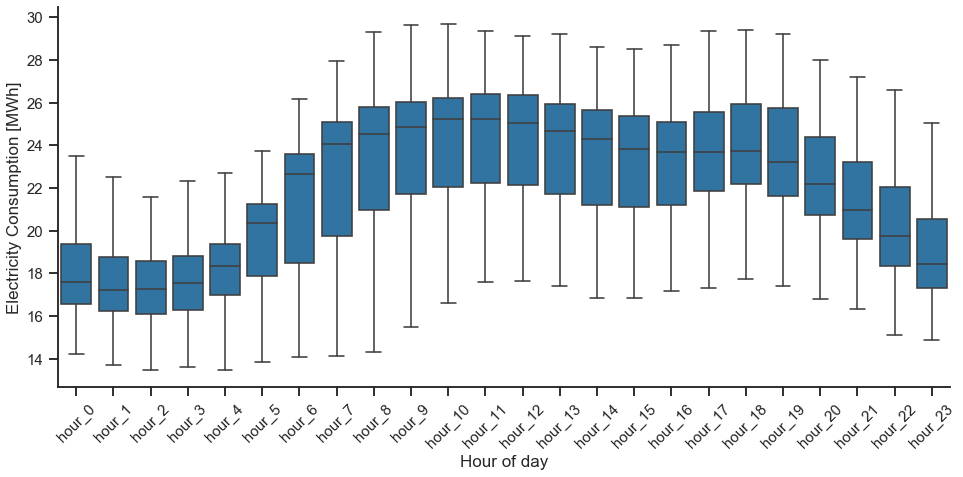

In [48]:
# Plot figure
fig, ax = plt.subplots(figsize=(16,7))
pxd = sns.boxplot(data=demand_daily, color = 'tab:blue',
                  linewidth=1.6, showfliers = False)
#demand_hourly.boxplot(sym='')
plt.xlabel('Hour of day', size=17)
plt.ylabel('Electricity Consumption [MWh]', size=17)
ax.tick_params(axis='both', labelsize=15)
#pxd.set(ylim=(0, 100))
plt.xticks(rotation=45)
sns.despine()

### Boxplot showing electricity consumption per day of week

In [49]:
# Get average consumption for each recorded day
df_hourly = pd.DataFrame(df_consumption['consumption'].resample('D').mean())
df_hourly['dow'] = df_hourly.index.weekday
demand_daily_temp = transform_to_windows(df_hourly, window = 'dow')
demand_daily = rename_cols(demand_daily_temp, 3, label = 'day_')

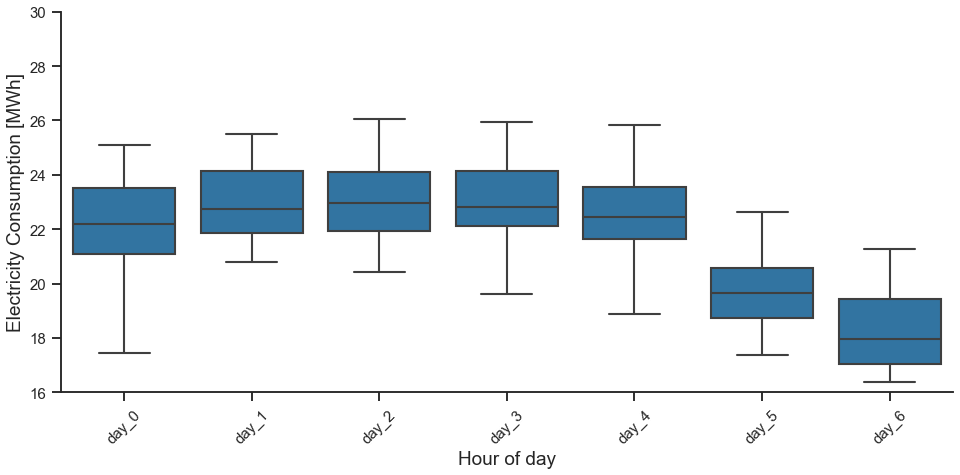

In [50]:
#fig = plt.figure(figsize=(16,7))
fig, ax = plt.subplots(figsize=(16,7))
pxd = sns.boxplot(data=demand_daily, color = 'tab:blue',
                  linewidth=2.1, showfliers = False)
#demand_hourly.boxplot(sym='')
plt.xlabel('Hour of day', size=19)
plt.ylabel('Electricity Consumption [MWh]', size=19)
ax.tick_params(axis='both', labelsize=15)
plt.xticks(rotation=45)
pxd.set(ylim=(16, 30))
sns.despine()

#### Calculate interquartile ranges per day of week

In [27]:
# Calculate interquartile ranges per day of week
import numpy
demand = demand_daily.iloc[:,0]
x = [~numpy.isnan(demand)]
q3, q1 = np.percentile(demand_daily.iloc[:,0], [75, 25])

In [28]:
# create list with interquartile range per day
interquart_ranges = list()
for i in range(len(demand_daily.columns)):
    x = demand_daily.iloc[:,i]
    x = x[~numpy.isnan(x)]
    q3, q1 = np.percentile(x, [75, 25])
    iqa = q3-q1
    interquart_ranges.append(iqa)


In [29]:
# calculate average non-weekend and weekend
iqa_non_weekend = round(np.mean(interquart_ranges[0:5]), 4)
iqa_weekend = round(np.mean(interquart_ranges[6:8]), 4)

print('The average interquartile range is {} on non-weekend days and {} on weekend days.'.format(iqa_non_weekend, iqa_weekend))

The average interquartile range is 2.1594 on non-weekend days and 2.3868 on weekend days.
